In [1]:
import numpy as np
import casadi as ca
from utils import *


#### **Part (a): define the mountain car environment**

Step 1: define the profile of mountain $h(p)$ with reference to horizontal displacement $p$
 - case 1: zero slope (linear case), $h(p) = c$
 - case 2: constant slope (linear case), $h(p) = k \cdot p$
 - case 3: varying slope (nonlinear case), $h(p) = k \cdot cos(\omega p)$
 - case 4: varying slope for under actuated case (nonlinear case), $h(p) = k \cdot sin(\omega p)$

In [2]:
# Define the profile of mountain h(p)
def h(p, case):

    if case == 1:  # zero slope
        h = 0

    elif case == 2: # constant slope
        h = (ca.pi * p) / 18

    elif case == 3: # varying slope
        h = ca.cos(3 * p)

    elif case == 4: # varying slope for underactuated case
        h = ca.sin(3 * p)

    return h


Step 2: define the mapping from profile $h(p)$ to inclination angle $\theta(p)$

- Transformation function from $h$ to $\theta$: $tan(\theta) = \frac{dh}{dp}$

- Hint: 
  1. input: CasAdi symbolic expression 'h_func'; output: CasAdi symbolic expression 'theta(p)';
  2. with symbolic expression 'h_func' as the input, we can directly solve the gradient $\frac{dh}{dp}$ with method 'ca.jacobian(h, p)';
  3. $\theta$ defined in radius;

- Notice:
  If the function $h(p)$ is defined numerically rather than symbolically, we can also use **numerical differentiation** to calculate $\frac{dh}{dp}$.

In [3]:
# Calculate inclination angle theta(p) based on terrain profile h(p)

def symbolic_theta(h_func):

    p = ca.SX.sym("p")

    h = h_func(p) 
    dh_dp = ca.jacobian(h, p)
    theta = ca.atan(dh_dp)
    
    return ca.Function("theta", [p], [theta])


Step 3: specify the parameters in environments to uniquely define a task for controller

- Task: start from given initial position $p_0$, to reach a given terget position $p_T$ (Stabilization)

- Arguments to be specified: 
  1. case: $n \in [1, 2, 3, 4]$, type: int
  2. initial state: $x_0 = [p_0, v_0] ^ T$, type: np.array
  3. terminal state: $x_T = [p_T, v_T] ^ T$, type: np.array
  4. constraints on states: lbx $\underline{x} = [\underline{p}, \underline{v}] ^ T$ & ubx $\overline{x} = [\overline{p}, \overline{v}] ^ T$, type: np.array or None (if no related limit)
  5. constraints on input: lbu $\underline{u}$ & ubu $\overline{u}$, type: float or None (if no related limit)

- At last, you can use the pre-defined method 'test_env()' to check the slope $h(p)$ and curve of inclination angle $\theta(p)$ as defined in step 2.



In [ ]:
# Define the initial / target state
case = 3 # 1, 2, 3, 4

initial_position = -1.2
initial_velocity = 0.0
target_position = 0.6
target_velocity = 0.0

state_lbs = np.array([-1.3, -1.0])
state_ubs = np.array([0.6, 1.0])
input_lbs = -0.50
input_ubs = 1.00

# Instantiate class 'Env'
env = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]), h, symbolic_theta, 
          state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs)

# Results visualisation
env.test_env() #  shape of slope (left side) and theta curve (right side) 

#### **Part (b): define the system dynamics**

Step 1: define the dynamcis of mountain car

- Notation: 
   - $p$: position in horizontal direction
   - $v$: velocity in horizontal direction
   - $a$: acceleration in body frame (tangent to the slope)

- Derivation of dynmaics: 

  consider the newton's second law along the slope: $a = $

- State space representation:

In [5]:
# Step2: define dynamics of 1d car
# Hint: use symbolic function theta_func as input;

def symbolic_dynamics(theta_func):

    p = ca.SX.sym("p")
    v = ca.SX.sym("v")
    a = ca.SX.sym("a")
    #Gravity = 9.81 # temporarily use the old model to test the code

    # call function theta from environment
    theta = theta_func(p)

    # expression of dynamics
    dpdt = v
    dvdt = a * ca.cos(theta)
    
    rhs = ca.vertcat(dpdt, dvdt)

    return ca.Function("dynamics", [ca.vertcat(p, v), ca.vertcat(a)], [rhs])


Step 2: specify the parameters for class 'Dynmaics' and instantiate the class

- Arguments to be specified: 
  1. names of state variables: $x = [p, v]^T$, type: list[str]
  2. names of input variables: $u = [a]$, type: list[str]
  3. symbolic expression of dynamics: function defined in step 1, type: ca.Function
  4. an object of class 'Env', type: Env

In [ ]:
# Define the states and input as symbolic variables
state_names = ["p", "v"]
input_names = ["a"]

# Instantiate class 'Dynamics'
# Hint: symbolic_dynamics depends on the methode from external object (theta), therefor external object 'env' must entry the constructor;
dynamics = Dynamics(state_names, input_names, symbolic_dynamics, env)


In [ ]:
# Define time setting of simulation
freq = 20

# Define weight matrix in stage and terminal cost
Q = np.diag([1, 1])
R = np.array([[1]]) # np.array([[0]])
Qf = Q

# Instantiate the DP controller class
controller_dp = DPController(env, dynamics, Q, R, Qf, freq)

# Define parameter for simulation
t_terminal = 8

# Instantiate the simulator, and then run the simulation
simulator_dp = Simulator(dynamics, controller_dp, env, 1/freq, t_terminal)
simulator_dp.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_dp = Visualizer(simulator_dp)
visualizer_dp.display_plots()
visualizer_dp.display_animation()


In [ ]:
# Instantiate the LQR controller class
controller_lqr = LQRController(env, dynamics, Q, R, freq)

# Instantiate the simulator, and then run the simulation
simulator_lqr = Simulator(dynamics, controller_lqr, env, 1/freq, t_terminal)
simulator_lqr.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_lqr = Visualizer(simulator_lqr)
visualizer_lqr.display_plots()
visualizer_lqr.display_animation()


In [ ]:
# Use trajectories getting from LQR to initialize iLQR
_, input_traj_lqr = simulator_lqr.get_trajectories()

# Instantiate the iLQR controller class
controller_ilqr = iLQRController(env, dynamics, Q, R, Qf, freq)
controller_ilqr.setup(input_traj_lqr)

# Instantiate the simulator, run the simulation, and plot the results
simulator_ilqr = Simulator(dynamics, controller_ilqr, env, 1/freq, t_terminal)
simulator_ilqr.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_ilqr = Visualizer(simulator_ilqr)
visualizer_ilqr.display_contrast_plots(simulator_lqr) # contrast with LQR
visualizer_ilqr.display_animation()



In [ ]:
# Define horizon and terminal cost for MPC (use the same setting as LQR)
Qf = Q
N = 20

# Instantiate the MPC controller class (use the same setting as LQR and iLQR)
controller_mpc = MPCController(env, dynamics, Q, R, Qf, freq, N)

# Instantiate the simulator, run the simulation, and plot the results
simulator_mpc = Simulator(dynamics, controller_mpc, env, 1/freq, t_terminal)
simulator_mpc.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_mpc = Visualizer(simulator_mpc)
visualizer_mpc.display_final_results()
#visualizer_mpc.display_contrast(simulator_lqr) # contrast with LQR
visualizer_mpc.display_animation()


In [1]:
import numpy as np
import casadi as ca
from utils import *

In [2]:
# Define profile of slope, the initial / target state
case = 1 # 1 or 2
initial_position = -1.2
initial_velocity = 0.0
target_position = 0.5
target_velocity = 0.0

state_lbs = np.array([-1.2, -1.0])
state_ubs = np.array([0.5, 1.0])
input_lbs = -0.50
input_ubs = 1.00

# Instantiate class 'Env'
env = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]),
          state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs)

dynamics = Dynamics(env)

mdp = Env_rl(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]),
             dynamics=dynamics, state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs)

#mdp.plot_t()



Building model... state 1/400
Building model... state 2/400
Building model... state 3/400
Building model... state 4/400
Building model... state 5/400
Building model... state 6/400
Building model... state 7/400
Building model... state 8/400
Building model... state 9/400
Building model... state 10/400
Building model... state 11/400
Building model... state 12/400
Building model... state 13/400
Building model... state 14/400
Building model... state 15/400
Building model... state 16/400
Building model... state 17/400
Building model... state 18/400
Building model... state 19/400
Building model... state 20/400
Building model... state 21/400
Building model... state 22/400
Building model... state 23/400
Building model... state 24/400
Building model... state 25/400
Building model... state 26/400
Building model... state 27/400
Building model... state 28/400
Building model... state 29/400
Building model... state 30/400
Building model... state 31/400
Building model... state 32/400
Building model...

In [3]:

# Define the control frequency for controller
freq = 10

# Instantiate the MPC controller class (use the same setting as LQR and iLQR)
controller_gpi = GPIController(mdp, freq)
controller_gpi.setup()
controller_gpi.plot_policy_map()


ValueError: cannot reshape array of size 400 into shape (2,400)

Simulation finished, will start plotting


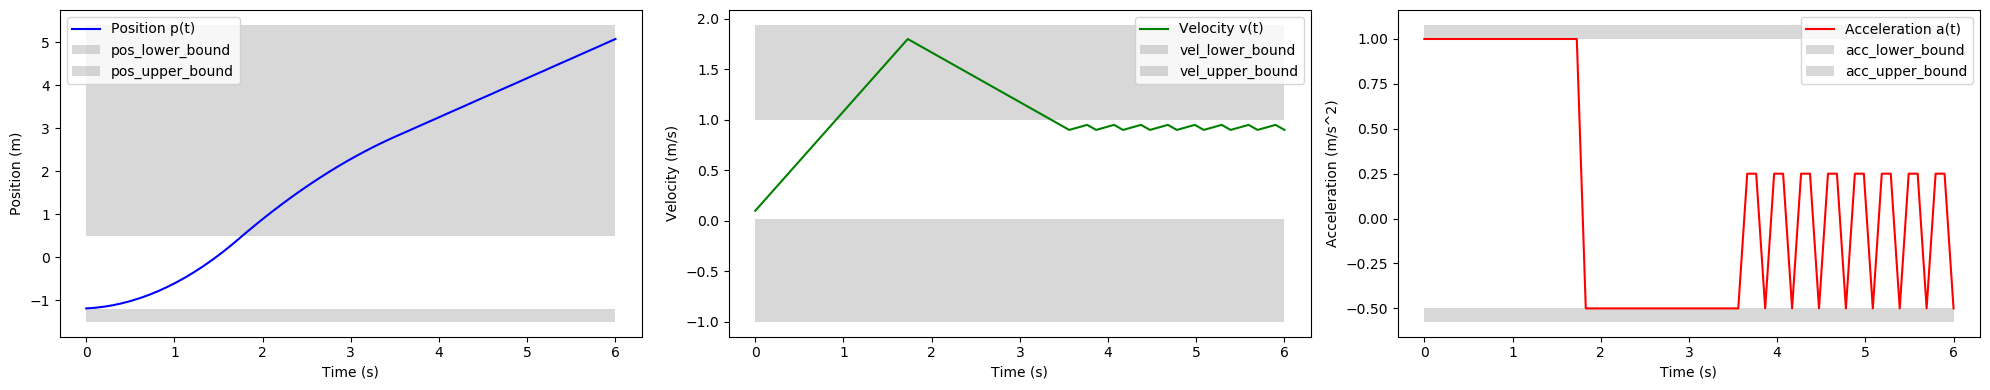

In [4]:
# Define time length for simulation
t_terminal = 6

# Instantiate the simulator, and then run the simulation
simulator_gpi = Simulator(dynamics, controller_gpi, env, 1/freq, t_terminal)
simulator_gpi.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_gpi = Visualizer(simulator_gpi)
visualizer_gpi.display_plots()